## FCNN with a boolean output indicating the likelihood of the image containing nerve

Trying to improve on the model that gave use 0.65

In [1]:
import sys
sys.path.append('../notebooks')
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [2]:
_d = np.load('../../data_128_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [3]:
print X.shape
print Y.shape

(5635, 128, 128)
(5635, 128, 128)


In [4]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices][:,None]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices][:,None]
Y_test = Y[test_indices][:,None,:,:]

In [5]:
print X_train.shape
print Y_train.shape
print Y_train_binary.shape
print X_train.min(), X_train.max()

print X_test.shape

(5071, 1, 128, 128)
(5071, 1, 128, 128)
(5071, 1)
0.0 1.0
(564, 1, 128, 128)


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


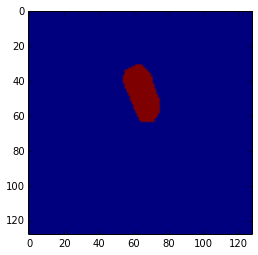

In [6]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [7]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [8]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, GaussianNoise, ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, PReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '13793' (I am process '15646')
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [9]:
import theano
print theano.config.device

gpu0


In [10]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [26]:
nf = 16

input_img = Input(shape=input_shape)
x = ZeroPadding2D((1, 1))(input_img)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool1 = x = Dropout(0.25, name='pool1')(x)

x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool2 = x = Dropout(0.25, name='pool2')(x)

x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool3 = x = Dropout(0.25, name='pool3')(x)

# -- binary presence part
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool4 = x = Dropout(0.1, name='pool4')(x)

x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool5 = x = Dropout(0.1, name='pool5')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(x)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# -- location map upsampling

x = pool3 
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='concat', concat_axis=1)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='concat', concat_axis=1)
x = ZeroPadding2D((1, 1))(x)
x = Convolution2D(nf, 3, 3)(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outbinmap = Reshape((16, 128, 128), name='outbinmap')(RepeatVector(16 * 128 * 128)(outbin))
x = merge([outbinmap, x], mode='mul')

# Flatten across filters
#x = Convolution2D(1, 3, 3, border_mode='same')(x)
#x = LeakyReLU()(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
optimizer='adam'
#optimizer=sgd
#optimizer=rmsprop

model.compile(optimizer=optimizer, loss='binary_crossentropy',
              loss_weights=[1., 0.01], metrics=['accuracy'])

In [27]:
print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_4 (InputLayer)               (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
zeropadding2d_37 (ZeroPadding2D)   (None, 1, 130, 130) 0           input_4[0][0]                    
____________________________________________________________________________________________________
convolution2d_37 (Convolution2D)   (None, 16, 128, 128)160         zeropadding2d_37[0][0]           
____________________________________________________________________________________________________
leakyrelu_43 (LeakyReLU)           (None, 16, 128, 128)0           convolution2d_37[0][0]           
___________________________________________________________________________________________

In [28]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils.visualize_util import plot
#plot(model, to_file='model.png')

In [29]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {'outmap': Y_train, 'outbin': Y_train_binary},
        batch_size=64,
        validation_data=(X_test, {'outmap': Y_test, 'outbin': Y_test_binary}),
        nb_epoch=60,# 40 + 10 + 10 + 5 + 5
        verbose=2,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adagrad', loss='mse')

Train on 5071 samples, validate on 564 samples
Epoch 1/60
Epoch 00000: val_loss improved from inf to 0.15519, saving model to weights.hdf5
27s - loss: 0.1446 - outmap_loss: 0.1323 - outbin_loss: 1.2309 - outmap_acc: 0.3750 - outbin_acc: 0.4214 - val_loss: 0.1552 - val_outmap_loss: 0.1481 - val_outbin_loss: 0.7049 - val_outmap_acc: 0.5603 - val_outbin_acc: 0.3688
Epoch 2/60
Epoch 00001: val_loss did not improve
27s - loss: 0.0756 - outmap_loss: 0.0681 - outbin_loss: 0.7488 - outmap_acc: 0.2717 - outbin_acc: 0.4179 - val_loss: 0.1795 - val_outmap_loss: 0.1719 - val_outbin_loss: 0.7630 - val_outmap_acc: 0.0783 - val_outbin_acc: 0.3688
Epoch 3/60
Epoch 00002: val_loss improved from 0.15519 to 0.06367, saving model to weights.hdf5
27s - loss: 0.0577 - outmap_loss: 0.0507 - outbin_loss: 0.6978 - outmap_acc: 0.1988 - outbin_acc: 0.5029 - val_loss: 0.0637 - val_outmap_loss: 0.0543 - val_outbin_loss: 0.9394 - val_outmap_acc: 0.1611 - val_outbin_acc: 0.3777
Epoch 4/60
Epoch 00003: val_loss impro

KeyboardInterrupt: 

In [30]:
if False:
    model_dir = '../models/fcnn_128_multiout'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.h5'))

In [31]:
import skimage.measure as measure

def predict(X):
    Y_pred, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 0 or Y_pred_binary[i] < 0.0:
            Y_pred[i,:] = 0
            
        avg_zone_proba = np.mean(Y_pred_proba[i][Y_pred[i] == 1])
        if avg_zone_proba < 0.0:
            Y_pred[i,:] = 0
    return Y_pred, Y_pred_proba, Y_pred_binary

Y_pred, Y_pred_proba, Y_pred_binary = predict(X_test)
print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)

test set score :  0.578055061502


In [32]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y_test[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

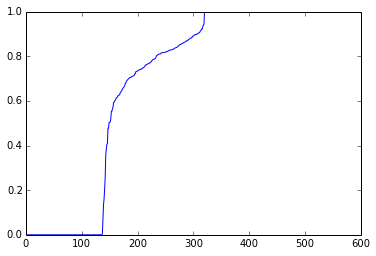

In [23]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

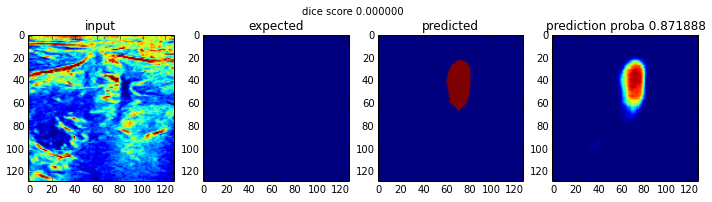

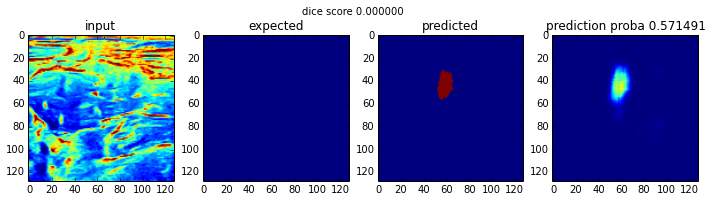

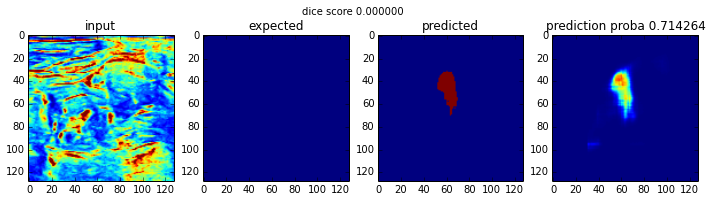

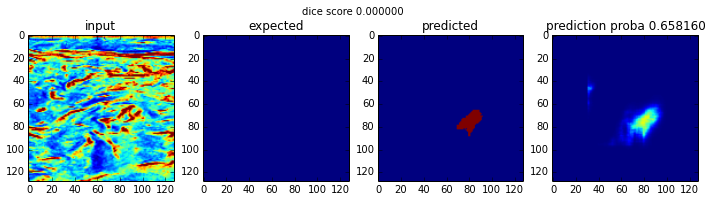

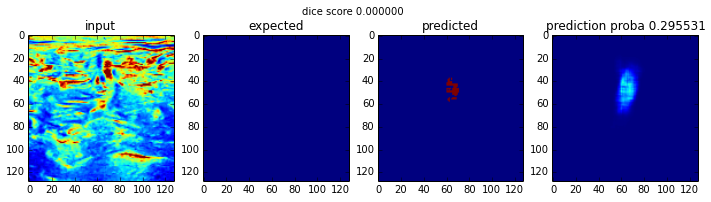

In [24]:
#i = 50
#i = 47

#for i in lowest[-450:-445]:
#for i in lowest[215:220]:
for i in lowest[10:15]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y_test[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_test[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_test[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    
    #blob_proba = np.mean(Y_pred_proba[i][Y_pred[i] == 1])
    pl.title('prediction proba %f' % Y_pred_binary[i])
    pl.imshow(Y_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Visualize filters

See http://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [81]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [82]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

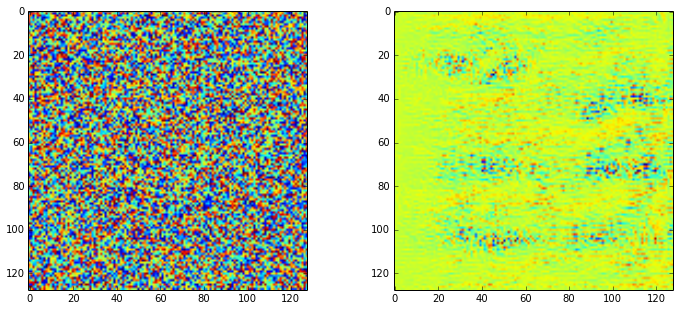

In [93]:
import keras.backend as K

layer_name = 'pool5'
filter_index = 0

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, filter_index, :, :])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([K.learning_phase(), input_img], [loss, grads])

# we start from a gray image with some noise
input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
input_img_data = input_img_data.astype(np.float32)

orig_img = input_img_data.copy()

# run gradient ascent for 20 steps
step = 0.1
for i in range(20):
    # 0 is to disable training_phase
    loss_value, grads_value = iterate([0, input_img_data])
    input_img_data += grads_value * step
    
img = input_img_data[0].squeeze()
#img = deprocess_image(img)

pl.figure(figsize=(12, 5))
pl.subplot(121)
pl.imshow(orig_img.squeeze())
pl.subplot(122)
pl.imshow(img)

# Run the model on kaggle'7 test set

In [137]:
_d = np.load('../../data_128_test.npz')
X_submit = _d['X']
test_fnames = _d['test_fnames']
Y_pred, Y_pred_proba, Y_pred_binary = predict(X_submit[:,None,:,:])

In [142]:
#pl.imshow(Y_pred_proba[50].squeeze())

In [143]:
OUTDIR='../../preds'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

for i in range(Y_pred.shape[0]):
    imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
    basename = os.path.splitext(test_fnames[i])[0]
    cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)